# Requirements

- install node2vec code and add executable to `node2vec` directory in top level of the project (code: https://snap.stanford.edu/node2vec)
- compile GED code (graph embedding divergence), 
  the base implementation of the framework in C (the code is included, and can also be found at      https://github.com/ftheberge/Comparing_Graph_Embeddings) 
- new package to install:
```
using PyCall
run(`$(PyCall.python) -m pip install graphrole`)
```

In [1]:
## the data directory
datadir="../Datasets/"

## location of the GED code
GED="../GED/GED"

## common colors
cls = ["red","green","blue"];

In [2]:
using PyCall
using PyPlot
using LightGraphs
using GraphPlot
using Statistics
using Random
using LinearAlgebra
using DataFrames
using CSV
using DecisionTree
using FreqTables
using StatsBase
using Clustering

In [3]:
ig = pyimport("igraph")
umap = pyimport("umap")
partition_igraph = pyimport("partition_igraph")
CHS = pyimport("sklearn.metrics").calinski_harabasz_score
AMI = pyimport("sklearn.metrics").adjusted_mutual_info_score
np = pyimport("numpy")
DBSCAN = pyimport("sklearn.cluster").dbscan
LogisticRegression = pyimport("sklearn.linear_model").LogisticRegression
roc_auc_score = pyimport("sklearn.metrics").roc_auc_score
roc_curve = pyimport("sklearn.metrics").roc_curve
npseed = pyimport("numpy.random").seed
npchoice = pyimport("numpy.random").choice
pickle_load = pyimport("pickle").load
RecursiveFeatureExtractor = pyimport("graphrole").RecursiveFeatureExtractor
RoleExtractor = pyimport("graphrole").RoleExtractor;

# A few useful functions

In [4]:
function ig2lg(ig_g)
    lg_g = SimpleGraph(ig_g.vcount())
    for e in ig_g.es()
        add_edge!(lg_g, e.source + 1, e.target + 1)
    end
    return lg_g
end

ig2lg (generic function with 1 method)

In [5]:
function binary_operator(u, v, op=:had)
    op == :had && return u .* v
    op == :l1 && return abs.(u .- v)
    op == :l2 && return (u .- v) .^ 2
    op == :avg && return (u .+ v) ./ 2.0
    throw(ArgumentError("unknown op"))
end

binary_operator (generic function with 2 methods)

In [6]:
function Hope(g, sim, dim; beta=0.01, alpha=0.5)
    dim = dim*2
    A = g.get_adjacency().data
    n = g.vcount()
    ## Katz
    if sim == :katz
        M_g = I - beta * A
        M_l = beta * A
    end
    ## Adamic-Adar
    if sim == :aa
        M_g = I
        D = diagm((x -> x > 1 ? 1/log(x) : 0.0).(g.degree()))
        M_l = A*D*A
        M_l[diagind(M_l)] .= 0.0
    end
    ## Common neighbors
    if sim == :cn
        M_g = I
        M_l = A*A
    end
    ## personalized page rank
    if sim == :ppr
        P = mapslices(A, dims=1) do x
            s = sum(x)
            iszero(s) ? fill(1/n, n) : x / s
        end
        M_g = I-alpha*P
        M_l = (1-alpha)*I
    end
    S = M_g \ M_l
    k = div(dim, 2)
    u, s, vt = svd(S)
    X1 = u[:, 1:k] * diagm(sqrt.(s[1:k]))
    ## undirected graphs have identical source and target embeddings
    if !g.is_directed()
        return X1
    else
        X2 = vtu[:, 1:k] * diagm(sqrt.(s[1:k]))
        return [X1 X2]
    end
end

Hope (generic function with 1 method)

In [7]:
## save to disk to compute divergence
function saveEmbedding(X, g, fn="_embed")
    names = g.vs.get_attribute_values("name")
    open(fn, "w") do f
        println(f, size(X,1), " ", size(X, 2))
        for i in axes(X, 1)
            print(f, names[i], " ")
            for j in axes(X, 2)
                print(f, X[i, j])
                 j < size(X, 2) && print(f, " ")
            end
            println(f)
        end
    end
end

saveEmbedding (generic function with 2 methods)

In [8]:
## Computing JS divergence with GED code given edgelist, communities and embedding
function JS(edge_file, comm_file, embed_file, entropy=false)
    if entropy
        x = `$GED -E -g $edge_file -c $comm_file -e $embed_file`
    else
        x = `$GED -g $edge_file -c $comm_file -e $embed_file`
    end
    io = IOBuffer()
    run(pipeline(x, stdout=io), wait=true)
    s = split(String(take!(io)), " ")
    return parse(Float64, s[2])
end

JS (generic function with 2 methods)

In [9]:
## Laplacian eigenmaps embedding
function LE(g, dim=2)
    L_sym = g.laplacian(normalized=true)
    w, v = eigen(L_sym)
    return real.(v[:, 2:dim+1])
end


LE (generic function with 2 methods)

In [10]:
## Read embedding from file in node2vec format
## Map to layout format
## for visualization, we use UMAP if dim > 2
function embed2layout(fn="_embed")
    D = CSV.read(fn, DataFrame, header=false, datarow=2)
    if eltype(D[!, end]) === Missing
        D = D[!, 1:end-1]
    end
    Y = Matrix(select(D, Not(1)))
    if size(Y,2) >  2
        Y = umap.UMAP().fit_transform(Y)
    end
    return Y
end

embed2layout (generic function with 2 methods)

In [11]:
function readEmbedding(fn="_embed"; N2K=nothing)
    D = CSV.read(fn, DataFrame, header=false, datarow=2)
    if eltype(D[!, end]) === Missing
        D = D[!, 1:end-1]
    end
    Y = Matrix(select(D, Not(1)))

    if N2K !== nothing
        x = [N2K[i] for i in D[:, 1]]
        Y = Y[sortperm(x), :]
    end
    return Y
end

readEmbedding (generic function with 2 methods)

# Load and prepare datasets

* g: small ABCD graph (100 nodes), mainly for visualization and quick exampes
* G: larger ABCD graph (1000 nodes), for experiments
* z: zachary graph, for visualzation

## 1. Small ABCD graph 

100 vertices, 350 edges; avg degreee: 7.0, communities: 3


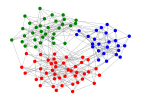

In [12]:
## read graph and communities
g = ig.Graph.Read_Ncol(datadir * "ABCD/abcd_100.dat", directed=false)
c = np.loadtxt(datadir * "ABCD/abcd_100_comms.dat", dtype="uint16", usecols=(1))
g.vs.set_attribute_values("comm", [c[parse(Int, x.attributes()["name"])] for x in g.vs])

## print a few stats
println(g.vcount()," vertices, ",
        g.ecount()," edges; ",
        "avg degreee: ", mean(g.degree()),
        ", communities: ",maximum(g.vs.get_attribute_values("comm")))

## ground truth
gt = Dict(enumerate(g.vs.get_attribute_values("comm")))
## map between name to key
n2k = Dict((v, k) for (k, v) in enumerate(g.vs.get_attribute_values("name")))

v_color = cls[g.vs.get_attribute_values("comm")]
g_lg = ig2lg(g)
Random.seed!(2)
gplot(g_lg,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

## 2. Larger ABCD graph

1000 vertices, 8327 edges; avg degreee: 16.654, communities: 12


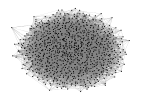

In [13]:
## read graph and communities
G = ig.Graph.Read_Ncol(datadir * "ABCD/abcd_1000.dat", directed=false)
C = np.loadtxt(datadir * "ABCD/abcd_1000_comms.dat", dtype="uint16", usecols=(1))
G.vs.set_attribute_values("comm", [C[parse(Int, x.attributes()["name"])] for x in G.vs])

## print a few stats
println(G.vcount()," vertices, ",
        G.ecount()," edges; ",
        "avg degreee: ", mean(G.degree()),
        ", communities: ",maximum(G.vs.get_attribute_values("comm")))

## ground truth
GT = Dict(enumerate(G.vs.get_attribute_values("comm")))
## map between name to key
N2K = Dict((v, k) for (k, v) in enumerate(G.vs.get_attribute_values("name")))

G_LG = ig2lg(G)
Random.seed!(2)
gplot(G_LG,
      NODESIZE=0.01, nodefillc="black",
      EDGELINEWIDTH=0.1, edgestrokec="gray") ## communities are far from obvious in 2d layout!

## 3. Zachary (karate) graph

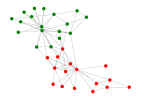

In [14]:
z = ig.Graph.Famous("zachary")
c = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1] .+ 1
z.vs.set_attribute_values("name", string.(0:z.vcount()-1))
z.vs.set_attribute_values("comm", [c[parse(Int, x.attributes()["name"])+1] for x in z.vs])

v_color = cls[z.vs.get_attribute_values("comm")]
z_lg = ig2lg(z)
Random.seed!(2)
gplot(z_lg,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Show various 2d layouts using small Zachary graph

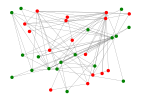

In [15]:
gplot(z_lg, layout=random_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

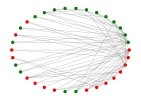

In [16]:
gplot(z_lg, layout=circular_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

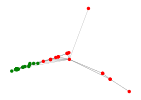

In [17]:
gplot(z_lg, layout=spectral_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Perform several embeddings -- Zachary graph
* node2vec from source code
* HOPE with different similarities
* Laplacian Eigenmaps
* visualize some good and bad results

We use the framework to compute the "graph embedding divergence" (GED.c)

In [18]:
L=DataFrame()
DIM=[5,10,15]

## Hope
for dim in DIM, sim in (:katz,:ppr, :cn, :aa)
    X = Hope(z,sim,dim)
    saveEmbedding(X,z)
    jsd = JS(datadir * "Zachary/zachary.edgelist", datadir * "Zachary/zachary.ecg", "_embed")
    push!(L, (dim=dim, alg="hope", param=sim, jsd=jsd))
end

## LE
for dim in DIM
    X = LE(z,dim)
    saveEmbedding(X,z)
    jsd = JS(datadir * "Zachary/zachary.edgelist", datadir * "Zachary/zachary.ecg", "_embed")
    push!(L, (dim=dim, alg="le", param=nothing,jsd=jsd), cols=:union)
end

## node2vec is in my path
for dim in DIM, (p,q) in [(1,0.1),(0.1,1),(1,1)]
        x = `../node2vec/node2vec -i:$datadir/Zachary/zachary.edgelist -o:_embed -d:$dim -p:$p -q:$q -l:15`
        run(x, wait=true)
        jsd = JS(datadir * "Zachary/zachary.edgelist" ,datadir * "Zachary/zachary.ecg", "_embed")
        push!(L, (dim=dim, alg="n2v", param=(p,q),jsd=jsd), cols=:union)
end


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Zachary/zachary.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=5
Length of walk per source. Default is 80 (-l:)=15
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=0.1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Zachary/zachary.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=5
Length of walk per source. Default is 80 (-l:)=15
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 

In [19]:
sort!(L, :jsd);
first(L, 10)

10×4 DataFrame
 Row │ dim    alg     param     jsd        
     │ Int64  String  Any       Float64    
─────┼─────────────────────────────────────
   1 │    15  n2v     (0.1, 1)  0.00171653
   2 │     5  n2v     (0.1, 1)  0.00210311
   3 │    10  n2v     (1, 1)    0.00267555
   4 │    15  hope    katz      0.00289819
   5 │    15  hope    ppr       0.00307659
   6 │     5  hope    cn        0.00333516
   7 │     5  hope    katz      0.00347263
   8 │     5  le                0.00380417
   9 │    10  hope    ppr       0.00385731
  10 │    15  hope    cn        0.00424242


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Zachary/zachary.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=15
Length of walk per source. Default is 80 (-l:)=15
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO


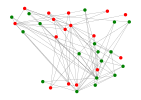

In [20]:
## re-run and plot top result
dim, algo, param, _ = first(L)
if algo=="n2v"
    p, q = param
    x = `../node2vec/node2vec -i:$datadir/Zachary/zachary.edgelist -o:_embed -d:$dim -p:$p -q:$q -l:15`
    run(x, wait=true)
elseif algo=="hope"
    X = Hope(z,param,dim)
    saveEmbedding(X,z) 
else
    X = LE(z,dim)
    saveEmbedding(X,z)
end

l = embed2layout()
gplot(z_lg, l[:, 1], l[:, 2],
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

In [21]:
last(L, 10)

10×4 DataFrame
 Row │ dim    alg     param     jsd        
     │ Int64  String  Any       Float64    
─────┼─────────────────────────────────────
   1 │     5  hope    aa        0.00559867
   2 │     5  hope    ppr       0.00594796
   3 │     5  n2v     (1, 1)    0.00699817
   4 │    10  n2v     (0.1, 1)  0.00702654
   5 │    15  hope    aa        0.00715518
   6 │    10  hope    aa        0.00773842
   7 │    10  n2v     (1, 0.1)  0.00818032
   8 │    15  n2v     (1, 0.1)  0.0083546
   9 │    10  le                0.00952332
  10 │     5  n2v     (1, 0.1)  0.0106505


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Zachary/zachary.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=5
Length of walk per source. Default is 80 (-l:)=15
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=0.1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO


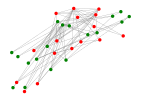

In [22]:
## re-run and plot bottom result
dim, algo, param, _ = last(L)
if algo=="n2v"
    p, q = param
    x = `../node2vec/node2vec -i:$datadir/Zachary/zachary.edgelist -o:_embed -d:$dim -p:$p -q:$q -l:15`
    run(x, wait=true)
elseif algo=="hope"
    X = Hope(z,param,dim)
    saveEmbedding(X,z) 
else
    X = LE(z,dim)
    saveEmbedding(X,z)
end

l = embed2layout()
gplot(z_lg, l[:, 1], l[:, 2],
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Perform several embeddings -- small ABCD  graph
* node2vec from source code
* HOPE different similarities
* Laplacian Eigenmaps
* visualize some good and bad results

In [23]:
L = DataFrame()
DIM = [2,4,8,16,24,32]

## Hope
for dim in DIM, sim in (:katz,:ppr, :cn, :aa)
    X = Hope(g,sim,dim)
    saveEmbedding(X,g)
    jsd = JS(datadir * "ABCD/abcd_100.dat", datadir * "ABCD/abcd_100.ecg", "_embed")
    push!(L, (dim=dim, alg="hope", param=sim, jsd=jsd))
end

## LE
for dim in DIM
    X = LE(g,dim)
    saveEmbedding(X,g)
    jsd = JS(datadir * "ABCD/abcd_100.dat", datadir * "ABCD/abcd_100.ecg", "_embed")
    push!(L, (dim=dim, alg="le", param=nothing,jsd=jsd), cols=:union)
end

## node2vec is in my path
for dim in DIM, (p,q) in [(1,0.1),(0.1,1),(1,1)]
        x = `../node2vec/node2vec -i:$datadir/ABCD/abcd_100.dat -o:_embed -d:$dim -p:$p -q:$q -l:15 -l:15`
        @show x
        run(x, wait=true)
        jsd = JS(datadir * "ABCD/abcd_100.dat" ,datadir * "ABCD/abcd_100.ecg", "_embed")
        @show (dim,p,q,jsd)
        push!(L, (dim=dim, alg="n2v", param=(p,q),jsd=jsd), cols=:union)
end

x = `../node2vec/node2vec -i:../Datasets//ABCD/abcd_100.dat -o:_embed -d:2 -p:1 -q:0.1 -l:15 -l:15`

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//ABCD/abcd_100.dat
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=2
Length of walk per source. Default is 80 (-l:)=15
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=0.1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO
(dim, p, q, jsd) = (2, 1, 0.1, 0.00277826)
x = `../node2vec/node2vec -i:../Datasets//ABCD/abcd_100.dat -o:_embed -d:2 -p:0.1 -q:1 -l:15 -l:15`

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//ABCD/abc

(dim, p, q, jsd) = (16, 1, 0.1, 0.001060908)
x = `../node2vec/node2vec -i:../Datasets//ABCD/abcd_100.dat -o:_embed -d:16 -p:0.1 -q:1 -l:15 -l:15`

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//ABCD/abcd_100.dat
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=16
Length of walk per source. Default is 80 (-l:)=15
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO
(dim, p, q, jsd) = (16, 0.1, 1, 0.0004615534)
x = `../node2vec/node2vec -i:../Datasets//ABCD/abcd_100.dat -o:_embed -d:16 -p:1 -q:1 -l:15 -l:15`

An algorithmic framework for representational learning on graphs. [Apr  5 2

In [24]:
sort!(L, :jsd)
first(L, 10)

10×4 DataFrame
 Row │ dim    alg     param   jsd         
     │ Int64  String  Any     Float64     
─────┼────────────────────────────────────
   1 │    16  hope    ppr     8.23976e-5
   2 │    16  hope    katz    8.99186e-5
   3 │    32  hope    ppr     9.62746e-5
   4 │     4  n2v     (1, 1)  0.000106067
   5 │    24  le              0.000128475
   6 │     8  le              0.000128605
   7 │    24  hope    ppr     0.00012949
   8 │    16  hope    cn      0.000140079
   9 │    24  hope    katz    0.000141626
  10 │    24  n2v     (1, 1)  0.000151918

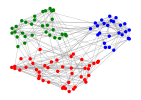

In [25]:
## re-run and plot top result
dim, algo, param, _ = first(L)
if algo=="n2v"
    p, q = param
    x = `../node2vec/node2vec -i:$datadir/ABCD/abcd_100.dat -o:_embed -d:$dim -p:$p -q:$q`
    run(x)
elseif algo=="hope"
    X = Hope(g,param,dim)
    saveEmbedding(X,g) 
else
    X = LE(g,dim)
    saveEmbedding(X,g)
end

l = embed2layout()
v_color = cls[g.vs.get_attribute_values("comm")]
gplot(g_lg, l[:, 1], l[:, 2],
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

In [26]:
last(L, 10)

10×4 DataFrame
 Row │ dim    alg     param     jsd        
     │ Int64  String  Any       Float64    
─────┼─────────────────────────────────────
   1 │    24  hope    aa        0.00142616
   2 │    32  hope    aa        0.00145591
   3 │    24  n2v     (1, 0.1)  0.00152017
   4 │     2  n2v     (0.1, 1)  0.00209534
   5 │     2  hope    ppr       0.00244788
   6 │     2  hope    cn        0.00277605
   7 │     2  hope    katz      0.00277826
   8 │     2  hope    aa        0.00277826
   9 │     2  n2v     (1, 0.1)  0.00277826
  10 │     2  n2v     (1, 1)    0.00277826


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//ABCD/abcd_100.dat
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=2
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO


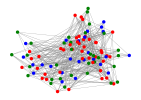

In [27]:
## re-run and plot bottom result
dim, algo, param, _ = last(L)
if algo=="n2v"
    p, q = param
    x = `../node2vec/node2vec -i:$datadir/ABCD/abcd_100.dat -o:_embed -d:$dim -p:$p -q:$q`
    run(x)
elseif algo=="hope"
    X = Hope(g,param,dim)
    saveEmbedding(X,g) 
else
    X = LE(g,dim)
    saveEmbedding(X,g)
end

l = embed2layout()
gplot(g_lg, l[:, 1], l[:, 2],
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Large ABCD graph -- find a good embedding with the framework
* we only look as 16 configurations with HOPE for now (for speed)
* we'll consider more in the large classification experiment later

The good embedding was generated using the code provided in the Python notebook

# Classification on larger ABCD graph

* we use a good embedding saved from above cell
* we use a random forest model on embedded space
* we split the data as train and test
* the goal is to recover the communities for each node


In [28]:
## used saved "best" embedding from above
X = readEmbedding(datadir * "ABCD/abcd_1000_embed_best")
y = string.(G.vs.get_attribute_values("comm"))
## train/test split
Random.seed!(1234)
to_train = falses(length(y))
to_train[1:round(Int, length(y)*0.25)] .= true
shuffle!(to_train)

X_train = X[to_train, :]
X_test = X[.!to_train, :]
y_train = y[to_train]
y_test = y[.!to_train]

model = build_forest(y_train, X_train, size(X, 2) ÷ 2, 100, 0.5)

y_pred = apply_forest(model, X_test)

cm = freqtable(y_test, y_pred)

12×12 Named Matrix{Int64}
Dim1 ╲ Dim2 │  1  10  11  12   2   3   4   5   6   7   8   9
────────────┼───────────────────────────────────────────────
1           │ 76   0   0   0   2   2   0   0   1   1   0   0
10          │  2  44   0   0   0   0   0   2   0   0   0   0
11          │  0   0  35   0   0   0   6   0   0   0   0   0
12          │  1   0   0  42   0   0   0   0   0   0   0   0
2           │  3   0   0   0  75   0   0   0   0   1   1   0
3           │  0   0   1   0   1  67   0   1   2   0   0   1
4           │  3   0   0   0   0   3  69   0   0   0   0   1
5           │  2   0   1   0   0   3   1  69   0   0   1   0
6           │  1   0   0   0   0   0   0   0  57   0   1   0
7           │  1   0   0   0   0   0   1   1   0  57   0   0
8           │  2   0   0   1   0   0   3   0   0   2  49   0
9           │  1   0   0   1   1   0   1   1   0   0   1  48

In [29]:
println("accuracy: $(sum(diag(cm))/length(y_test))")

accuracy: 0.9173333333333333


In [30]:
## compare with random classifier -- assuming we know only the number of classes (12)
describe([sum(diag(freqtable(rand(1:12, length(y_test)), y_test)))/length(y_test) for i in 1:10000])

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.083351
Minimum:        0.044000
1st Quartile:   0.076000
Median:         0.082667
3rd Quartile:   0.090667
Maximum:        0.124000
Type:           Float64


In [31]:
## compare with random classifier -- using class proportions in training data
describe([sum(diag(freqtable(rand(y_train, length(y_test)), y_test)))/length(y_test) for i in 1:10000])

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.088783
Minimum:        0.052000
1st Quartile:   0.081333
Median:         0.088000
3rd Quartile:   0.096000
Maximum:        0.132000
Type:           Float64


# Clustering
* we run graph clustering (Louvain, ECG)
* we compare with vector space embedding using same embedding
* we use k-means (various k) and DBSCAN
* recall there are 12 ground truth community

In [32]:
## again we use 'good' embedding from before
X = readEmbedding(datadir * "ABCD/abcd_1000_embed_best")

L = DataFrame()
K = [6,9,12,15,24] ## for k-means (real number of clusters is 12)
REP = 30

for i in 1:REP
    ## kmeans
    for k in K
        labels = kmeans(X', k).assignments
        scr = CHS(X, labels)
        ami = AMI(G.vs.get_attribute_values("comm"), labels)
        push!(L, (method="km", param=k, scr=scr, ami=ami))
    end
    ## ECG
    ec = G.community_ecg().membership
    scr = G.modularity(ec)
    ami = AMI(G.vs.get_attribute_values("comm"),ec)
    push!(L, (method="ecg", param=nothing, scr=scr, ami=ami), cols=:union)
    ## Louvain -- permute as this is not done in igraph
    p = randperm(G.vcount()) .- 1
    GG = G.permute_vertices(Any[x for x in p])
    l = GG.community_multilevel().membership
    ll = similar(l)
    for i in 1:length(l)
        ll[i] = l[p[i] + 1]
    end
    scr = G.modularity(ll)
    ami = AMI(G.vs.get_attribute_values("comm"),ll)
    push!(L, (method="ml", param=nothing, scr=scr, ami=ami), cols=:union)
end

combine(groupby(L, :method), x -> last(sort(x, :scr)))

3×4 DataFrame
 Row │ method  param   scr        ami      
     │ String  Union…  Float64    Float64  
─────┼─────────────────────────────────────
   1 │ km      12      17.3325    0.943812
   2 │ ecg              0.355177  0.995294
   3 │ ml               0.354881  0.987246

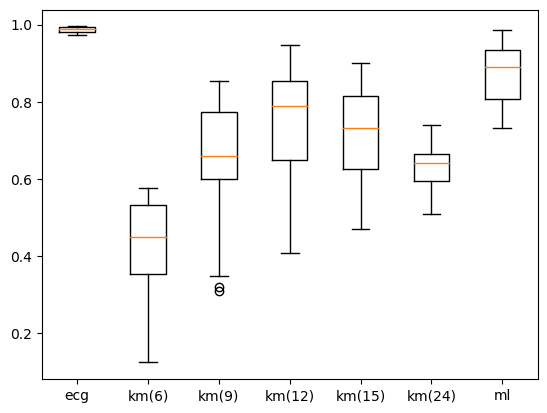

In [33]:
gL = groupby(L, [:method, :param], sort=true)

boxplot([sdf.ami for sdf in gL])
xticks(1:7, [isnothing(p) ? m : "$m($p)" for (m,p) in keys(gL)]);

In [34]:
## DBSCAN -- we tried different epsilon and dim
## test via calinski_harabasz_score (CHS) or silhouette_score or davies_bouldin_score
## best result obtained empirically with min_samples = 8

top = 0
for dim in [4,8,16,24,32,40,48,64], ms in [8]
    U = umap.UMAP(n_components=24).fit_transform(X)
    for e in 0.4:0.0025:0.5
        cl = DBSCAN(U, eps=e, min_samples=ms)
        labels = cl[2]
        s = CHS(U,labels) ## score
        if s > top
            global top = s
            global e_top = e
            global d_top = dim
            global m_top = ms
        end
    end
end

U = umap.UMAP(n_components=d_top).fit_transform(X)
cl = DBSCAN(U, eps=e_top, min_samples=m_top)
labels = cl[2]

b = labels .> -1
println("AMI without outliers: ", AMI(G.vs.get_attribute_values("comm")[b], labels[b]))
println("AMI with outliers: ", AMI(G.vs.get_attribute_values("comm"), labels))

AMI without outliers: 0.8372843476425416
AMI with outliers: 0.6554837303740909


# Link prediction

* we drop 10% edges and re-compute the embedding
* we train a logistic regression model
* we apply final model to test set

## First try with noisy graph

Recall that xi=0.6, the proportion of noise edges


In [35]:
## pick 10% edges at random, save new graph as Gp
Random.seed!(12345)
test_size = round(Int, 0.1*G.ecount())

npseed(123456)
test_eid = npchoice(G.ecount(),size=test_size,replace=false)

#test_eid = sample(0:G.ecount()-1, test_size, replace=false)
Gp = G.copy()
Gp.delete_edges(test_eid)

## compute embedding on Gp 
X = Hope(Gp, :ppr, 48);

In [36]:
## Train model with Hadamard binary operator (other choices are 'l1', 'l2 and 'avg')
op = :had

## Build training data, first the edges
F = [binary_operator(X[e.tuple[1]+1, :],X[e.tuple[2]+1, :],op) for e in Gp.es]
sz = length(F)
f = [fill(1, sz); fill(0, sz)]

## then for equal number of non-edges (we over-sample to drop edges and collisions from the list)
e = [minmax(rand(0:Gp.vcount()-1), rand(0:Gp.vcount()-1)) for i in 1:2*sz]
unique!(e) # drop collisions
filter!(((a, b),) -> Gp.get_eid(a, b, directed=false, error=false) == -1, e)
non_edges = e[1:sz]
## features for node pairs without edges
for (a, b) in non_edges
    push!(F, binary_operator(X[a+1, :],X[b+1, :], op))
end

## train model
logreg = LogisticRegression()
logreg.fit(F, f)

## prepare test set, first with all dropped edges from G 
X_test = [(e = G.es[i+1]; binary_operator(X[e.tuple[1]+1, :],X[e.tuple[2]+1, :],op)) for i in test_eid]
szt = length(X_test)
y_test = [fill(1, szt); fill(0, szt)]

## then for equal number of non-edges (we over-sample to drop edges and collisions from the list)
e2 = [minmax(rand(0:G.vcount()-1), rand(0:G.vcount()-1)) for i in 1:2*szt]
unique!(e2) # drop collisions
filter!(((a, b),) -> G.get_eid(a, b, directed=false, error=false) == -1, e2)
non_edges2 = e2[1:szt]
for (a, b) in non_edges2
    push!(X_test, binary_operator(X[a+1, :],X[b+1, :], op))
end

## apply the model to test data
println("Accuracy of logistic regression classifier with $op on test set: ", logreg.score(X_test, y_test))
print("AUC: ",roc_auc_score(y_test, logreg.predict_proba(X_test)[:,2]))

Accuracy of logistic regression classifier with had on test set: 0.5732292917166867
AUC: 0.6439271987306326

## Link prediction with less noisy graph

In [37]:
## read graph and communities - graph with xi=0.2
G2 = ig.Graph.Read_Ncol(datadir * "ABCD/abcd_1000_xi2.dat", directed=false)
C = np.loadtxt(datadir * "ABCD/abcd_1000_xi2_comms.dat", dtype="uint16", usecols=(1))
G.vs.set_attribute_values("comm", [C[parse(Int, x.attributes()["name"])] for x in G.vs])

## pick 10% edges at random, save new graph as Gp
Random.seed!(12345)
test_size = round(Int, 0.2*G2.ecount())

npseed(123456)
test_eid = npchoice(G2.ecount(),size=test_size,replace=false)

#test_eid = sample(0:G.ecount()-1, test_size, replace=false)
Gp = G2.copy()
Gp.delete_edges(test_eid)

## compute embedding on Gp 
X = Hope(Gp, :ppr, 48);

In [38]:
## Train model with Hadamard binary operator (other choices are 'l1', 'l2 and 'avg')
op = :had

## Build training data, first the edges
F = [binary_operator(X[e.tuple[1]+1, :],X[e.tuple[2]+1, :],op) for e in Gp.es]
sz = length(F)
f = [fill(1, sz); fill(0, sz)]

## then for equal number of non-edges (we over-sample to drop edges and collisions from the list)
e = [minmax(rand(0:Gp.vcount()-1), rand(0:Gp.vcount()-1)) for i in 1:2*sz]
unique!(e) # drop collisions
filter!(((a, b),) -> Gp.get_eid(a, b, directed=false, error=false) == -1, e)
non_edges = e[1:sz]
## features for node pairs without edges
for (a, b) in non_edges
    push!(F, binary_operator(X[a+1, :],X[b+1, :], op))
end

## train model
logreg = LogisticRegression()
logreg.fit(F, f)

## prepare test set, first with all dropped edges from G 
X_test = [(e = G2.es[i+1]; binary_operator(X[e.tuple[1]+1, :],X[e.tuple[2]+1, :],op)) for i in test_eid]
szt = length(X_test)
y_test = [fill(1, szt); fill(0, szt)]

## then for equal number of non-edges (we over-sample to drop edges and collisions from the list)
e2 = [minmax(rand(0:G2.vcount()-1), rand(0:G2.vcount()-1)) for i in 1:2*szt]
unique!(e2) # drop collisions
filter!(((a, b),) -> G2.get_eid(a, b, directed=false, error=false) == -1, e2)
non_edges2 = e2[1:szt]
for (a, b) in non_edges2
    push!(X_test, binary_operator(X[a+1, :],X[b+1, :], op))
end

## apply the model to test data
println("Accuracy of logistic regression classifier with $op on test set: ", logreg.score(X_test, y_test))
print("AUC: ",roc_auc_score(y_test, logreg.predict_proba(X_test)[:,2]))

Accuracy of logistic regression classifier with had on test set: 0.7427995391705069
AUC: 0.8574418255855932

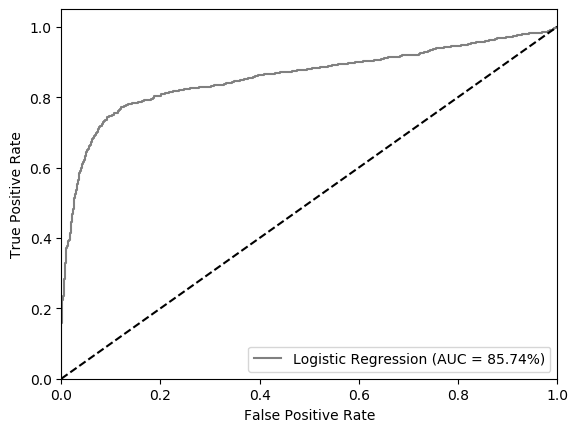

In [39]:
logit_roc_auc = round(10000*roc_auc_score(y_test, logreg.predict_proba(X_test)[:,2]))/100
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,2])
plot(fpr, tpr, color="gray",label="Logistic Regression (AUC = $logit_roc_auc%)")
plot([0, 1], [0, 1],"k--")
xlim([0.0, 1.0])
ylim([0.0, 1.05])
xlabel("False Positive Rate")
ylabel("True Positive Rate")
title("")
legend(loc="lower right");

## Larger study -- use accuracy for picking embedding

- we training-validation-test split
- this can be long to run -- a pickle file with the results is included in data directory
- to re-run from scratch please check Python notebooks

In [40]:
## load L and train/val/test ids
fh = py"open"(datadir * "ABCD/abcd_1000_embeddings.pkl", "rb")
id_train,id_val,id_trainval,id_test,L = pickle_load(fh)
fh.close()
y_all = G.vs.get_attribute_values("comm")
y_train = [y_all[i+1] for i in id_train]
y_trainval = [y_all[i+1] for i in id_trainval]
y_val = [y_all[i+1] for i in id_val]
y_test = [y_all[i+1] for i in id_test];

In [41]:
R = identity.(DataFrame(L,[:dim,:algo,:param,:div,:acc]))
print("Kendall's correlation: ", corkendall(R.div, R.acc))

Kendall's correlation: -0.21184265802735136

In [42]:
## sort by Divergence on validation set
sort!(R, :div)
R.rank_div = axes(R, 1)
first(R, 5)

5×6 DataFrame
 Row │ dim    algo    param  div          acc      rank_div 
     │ Int64  String  Any    Float64      Float64  Int64    
─────┼──────────────────────────────────────────────────────
   1 │    48  n2v     0.5 1  0.000344645    0.66          1
   2 │    32  n2v     1 0.5  0.0003835      0.66          2
   3 │    48  n2v     1 0.5  0.000408097    0.668         3
   4 │    32  n2v     0.5 1  0.000459046    0.684         4
   5 │    32  n2v     1 1    0.000465698    0.704         5

In [43]:
## sort by Accuracy on validation set
sort!(R, :acc, rev=true)
R.rank_acc = axes(R, 1)
first(R, 5)

5×7 DataFrame
 Row │ dim    algo    param  div          acc      rank_div  rank_acc 
     │ Int64  String  Any    Float64      Float64  Int64     Int64    
─────┼────────────────────────────────────────────────────────────────
   1 │    32  hope    ppr    0.00120257     0.948        23         1
   2 │    24  hope    ppr    0.00127398     0.948        25         2
   3 │    16  hope    ppr    0.0014113      0.94         27         3
   4 │    48  hope    ppr    0.00114377     0.936        20         4
   5 │    24  le      0      0.000756688    0.932        14         5

In [44]:
## quite a range of accuracy on the validation set!
last(R, 5)

5×7 DataFrame
 Row │ dim    algo    param  div         acc      rank_div  rank_acc 
     │ Int64  String  Any    Float64     Float64  Int64     Int64    
─────┼───────────────────────────────────────────────────────────────
   1 │     2  hope    katz   0.00363342    0.184        53        66
   2 │     2  n2v     1 1    0.00363342    0.176        69        67
   3 │     4  n2v     0 1    0.00350524    0.144        45        68
   4 │     2  n2v     0 1    0.003575      0.112        48        69
   5 │     2  n2v     0.5 1  0.00363342    0.104        68        70

##  Apply to test set. 

This takes several minutes to run so a pickle file is provided.

Source codes for generating the data are provided in Python notebooks.

In [45]:
## load L and train/val/test ids
fh = py"open"(datadir * "ABCD/abcd_1000_embeddings_test.pkl", "rb")
R.test = pickle_load(fh)
fh.close()
println("mean accuracy over all models on test set:",mean(R.test))

mean accuracy over all models on test set:0.6198571428571428


In [46]:
## sort by Accuracy on validation set
sort!(R, :test, rev=true)
R.rank_test = axes(R, 1)
first(R, 5)

5×9 DataFrame
 Row │ dim    algo    param  div          acc      rank_div  rank_acc  test    ⋯
     │ Int64  String  Any    Float64      Float64  Int64     Int64     Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    32  le      0      0.000669636    0.908         9         8    0.966 ⋯
   2 │    48  le      0      0.000596903    0.916         8         7    0.962
   3 │    16  le      0      0.000875134    0.928        17         6    0.96
   4 │    24  le      0      0.000756688    0.932        14         5    0.956
   5 │    16  hope    ppr    0.0014113      0.94         27         3    0.95  ⋯
                                                                1 column omitted

In [47]:
## top results on test set w.r.t. divergence on validation set
sort!(R, :div)
top_div = R.test[1:10]

## top results on test set w.r.t. accuracy on validation set
sort!(R, :acc, rev=true)
top_acc = R.test[1:10]

10-element Vector{Float64}:
 0.946
 0.936
 0.95
 0.94
 0.956
 0.96
 0.962
 0.966
 0.884
 0.89

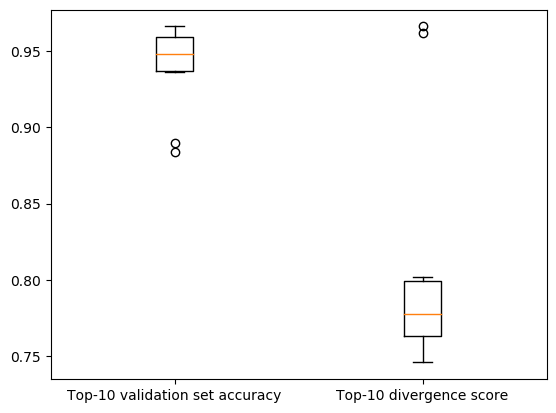

In [48]:
boxplot([top_acc, top_div])
xticks(1:2, ["Top-10 validation set accuracy","Top-10 divergence score"]);

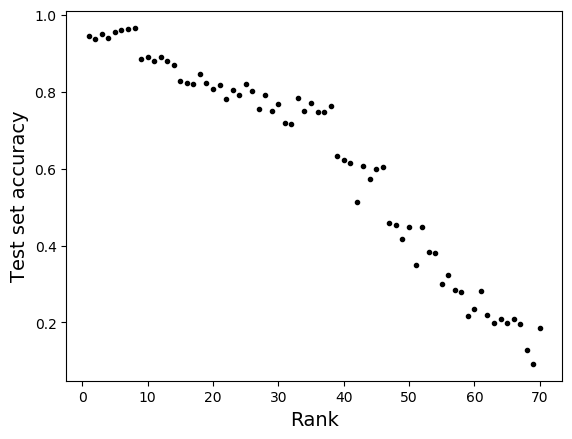

In [49]:
plot(R.rank_acc,R.test,".",color="black")
xlabel("Rank",fontsize=14)
ylabel("Test set accuracy",fontsize=14);

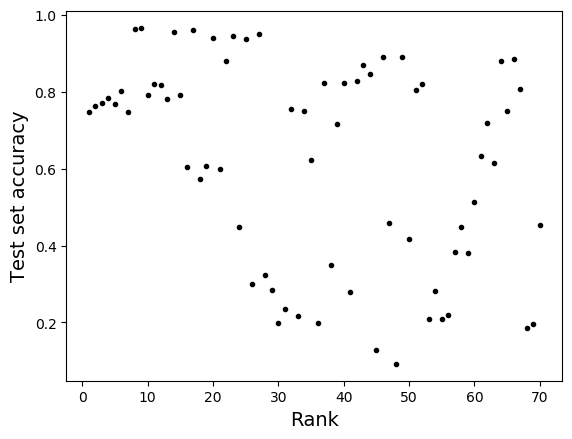

In [50]:
plot(R.rank_div,R.test,".",color="black")
xlabel("Rank",fontsize=14)
ylabel("Test set accuracy",fontsize=14);

In [51]:
print((cor(R.rank_acc,R.test),
       cor(R.rank_div,R.test)))

(-0.966225935264909, -0.3778024461141235)

In [52]:
function sample_random_classifier()
    y_pred = sample(1:12, Weights(proptable(y_trainval)), length(y_test))
    return sum(diag(proptable(y_test, y_pred)))
end
println("Random classifier accuracy on test set: ")
describe([sample_random_classifier() for i in 1:10000])

Random classifier accuracy on test set: 
Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.090566
Minimum:        0.048000
1st Quartile:   0.082000
Median:         0.090000
3rd Quartile:   0.100000
Maximum:        0.144000
Type:           Float64


## ReFex: illustrate roles on Zachary graph

We use the 'graphrole' package


In [53]:
# extract features
feature_extractor = RecursiveFeatureExtractor(z, max_generations=5)
features = feature_extractor.extract_features()
println("Features extracted from $(feature_extractor.generation_count) recursive generations:")
features.head(10)

Features extracted from 3 recursive generations:


PyObject    external_edges(mean)(mean)  degree(mean)  ...  external_edges  internal_edges
0                   19.637500      4.312500  ...              17              34
1                   22.422685      5.777778  ...              19              21
2                   25.537083      6.600000  ...              34              21
3                   23.717361      7.666667  ...              20              16
4                   17.979167      7.666667  ...              16               5
5                   17.234375      6.250000  ...              15               7
6                   17.234375      6.250000  ...              15               7
7                   26.342708     10.250000  ...              25              10
8                   27.214363     11.800000  ...              44              10
9                   28.108824     13.500000  ...              25               2

[10 rows x 7 columns]

In [54]:
# assign node roles in a dictionary
role_extractor = RoleExtractor(n_roles=3)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles
role_extractor.role_percentage.head()

PyObject      role_0    role_1    role_2
0  0.835323  0.066075  0.098602
1  0.603568  0.274359  0.122073
2  0.420363  0.064326  0.515310
3  0.511453  0.359224  0.129323
4  0.307913  0.668059  0.024028

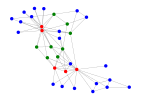

In [55]:
unique_roles = sort(unique(values(node_roles)))
cls = ["red","blue","green"]
# map roles to colors
role_colors = Dict(unique_roles .=> cls)
v_color = [role_colors[node_roles[i]] for i in 0:z.vcount()-1]
Random.seed!(2)
gplot(z_lg,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Anomaly detection

## Dataset -- American College Football Graph

[REF]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman
PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799


Teams are part of 12 conferences (the 'communities'):
*   0 = Atlantic Coast
*   1 = Big East
*   2 = Big Ten
*   3 = Big Twelve
*   4 = Conference USA
*   5 = Independents
*   6 = Mid-American
*   7 = Mountain West
*   8 = Pacific Ten
*   9 = Southeastern
*  10 = Sun Belt
*  11 = Western Athletic

14 teams out of 115 appear as anomalies as can be seen in Figure 5 of [REF], namely:
- 5 teams in #5 conference (Independent) play teams in other conferences (green triangles)
- 7 teams in #10 conference (Sun Belt) are broken in 2 clumps (pink triangles) 
- 2 teams from #11 conference play mainly with #10 conference (red triangles)

Here, we try to recover those anomalous teams by running several embeddings (we use node2vec):

- for each embedding:
 - compute divergence using our framework
 - also compute entropy of b-vector for each node (probability distribution of edges w.r.t. every community in the geometric Chung-Lu model)
- plot entropy vs divergence
- for some good/bad embedding, boxplot entropy of anomalous vs other nodes



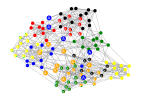

In [56]:
comm_color = ["red", "red", "green", "green", "blue", "blue",
              "black", "black", "yellow", "yellow", "orange", "orange"]
comm_label = repeat(["", "x"], 6)

## read graph and communities
g = ig.Graph.Read_Ncol(datadir * "Football/football.edgelist", directed=false)
c = parse.(Int, readlines(datadir * "Football/football.community"))
g.vs.set_attribute_values("community", [c[1 + parse(Int, x.attributes()["name"])] for x in g.vs])

anomaly = Int[c in [5, 10] || n in ["28", "58"] for
              (c, n) in zip(g.vs.get_attribute_values("community"), g.vs.get_attribute_values("name"))]

# communities are marked with color and an optional "x" mark on the node
# if the mark is "A" and node is a bit larger it is an anomaly
Random.seed!(1234)
lab = comm_label[g.vs.get_attribute_values("community") .+ 1]
lab[Bool.(anomaly)] .= "A"
gplot(ig2lg(g),
      NODESIZE=0.03 .+ anomaly ./75, nodefillc=comm_color[g.vs.get_attribute_values("community") .+ 1],
      nodelabel=lab,
      nodelabelc="white",
      EDGELINEWIDTH=0.2, edgestrokec="gray")

In [ ]:
best_jsd = 1.1
worst_jsd = -0.1
## node2vec with varying parameters (60 embeddings)
L = DataFrame()
for dim in 2:2:24
    for (p,q) in [(1.0, 0.5),(0.5, 1.0),(1.0, 0.01),(0.01, 1.0),(1.0, 1.0)]
        x = `../node2vec/node2vec -i:$datadir/Football/football.edgelist -o:_embed -d:$dim -p:$p -q:$q`
        run(x, wait=true)
        jsd = JS(datadir * "Football/football.edgelist" ,datadir * "Football/football.ecg", "_embed", true)
        if jsd < best_jsd
            cp("_entropy", "_entropy_best", force=true)
            global best_jsd = jsd
        end
        if jsd > worst_jsd
            cp("_entropy", "_entropy_worst", force=true)
            global worst_jsd = jsd
        end
        ent = parse.(Float64, getindex.(split.(readlines("_entropy"), ','), 2))
        roc = roc_auc_score(anomaly, ent)
        push!(L, (dim=dim, algo="n2v", param=(p,q),jsd=jsd, auc=roc))
    end
end


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Football/football.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=2
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=0.5
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Football/football.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=2
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Football/football.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=6
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=0.01
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Football/football.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=6
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Defaul


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Football/football.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=10
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Football/football.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=12
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Football/football.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=16
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.5
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Football/football.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=16
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Defau

In [ ]:
sort!(L, :jsd)
first(L, 5)

In [ ]:
last(L, 5)

In [ ]:
## auc vs divergence (jsd)
plot(L.jsd,L.auc,"o",color="black")
xlabel("JS Divergence",fontsize=14)
ylabel("AUC",fontsize=14);

In [ ]:
## Entropy scores - some good embedding
ent = parse.(Float64, getindex.(split.(readlines("_entropy_best"), ','), 2))
plt.boxplot([ent[anomaly .== 0], ent[anomaly .== 1]],
             labels=["Regular", "Anomalous"], sym=".",whis=(0,100), widths=.5)
title("Low divergence embedding",fontsize=14)
plt.ylabel("Entropy",fontsize=14);

In [ ]:
## Entropy scores - not so good embedding
ent = parse.(Float64, getindex.(split.(readlines("_entropy_worst"), ','), 2))
plt.boxplot([ent[anomaly .== 0], ent[anomaly .== 1]],
             labels=["Regular", "Anomalous"], sym=".",whis=(0,100), widths=.5)
title("Low divergence embedding",fontsize=14)
plt.ylabel("Entropy",fontsize=14);

## AUC using average rank with several top embeddings

In [ ]:
k = 7
ranking = fill(0.0, g.vcount())
for i in 1:k
    dim = L.dim[i]
    p,q = L.param[i]
    x = `../node2vec/node2vec -i:$datadir/Football/football.edgelist -o:_embed -d:$dim -p:$p -q:$q`
    run(x, wait=true)
    jsd = JS(datadir * "Football/football.edgelist" ,datadir * "Football/football.ecg", "_embed", true)
    ent = parse.(Float64, getindex.(split.(readlines("_entropy"), ','), 2))
    global ranking .+= ordinalrank(ent)
end

In [ ]:
println("AUC: ",roc_auc_score(anomaly, ranking))